# o4-mini (Azure OpenAI) Financial Sentiment Inference

This notebook evaluates the `o4-mini` model deployed via **Azure OpenAI** as a zero-shot sentiment classifier.

We provide system instructions and a sample sentence, and expect one of: `positive`, `neutral`, or `negative`.

**Objective:** Understand how a general LLM performs on specialized financial sentiment tasks.


In [7]:
import os
import sys

from dotenv import load_dotenv

sys.path.append("../scripts")

import pandas as pd
from metrics import per_source_metrics
from openai import AzureOpenAI
from plot_utils import plot_confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

## Load Validation Data

We'll use the same `val.csv` used in other experiments.


In [ ]:
val_df = pd.read_csv("../data/processed/val.csv")

print("Validation samples:", len(val_df), "\n")
print(val_df["label"].value_counts())

Validation samples: 1781 

label
neutral     1064
positive     443
negative     274
Name: count, dtype: int64


## Azure OpenAI Configuration

Make sure your API key and endpoint are securely loaded.


In [ ]:
endpoint = os.getenv("AZURE_ENDPOINT")
api_key = os.getenv("AZURE_API_KEY")
model_name = "o4-mini"
model_deployment_name = "o4-mini"

client = AzureOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint=endpoint,
    api_key=api_key,
)

## Inference

We provide a sentence and prompt the LLM to classify it as `positive`, `neutral`, or `negative`.


In [ ]:
prompts = [
    {
        "role": "system",
        "content": "You are a financial sentiment classifier. Respond with one word: neutral, positive, or negative.",
    }
]

sentences = val_df["sentence"].tolist()
true_labels = val_df["label"].tolist()

In [16]:
# preds = []

for sentence in tqdm(sentences[1161:]):
    response = client.chat.completions.create(
        messages=prompts
        + [
            {
                "role": "user",
                "content": f"Classify the sentiment of this sentence: {sentence}",
            }
        ],
        max_completion_tokens=10000,
        model=model_deployment_name,
    )
    result = response.choices[0].message.content.strip().lower()
    preds.append(result)

    # print(f"{i}\no4-mini: {result}\nvalidation: {true_labels[i]}\n")

100%|██████████| 620/620 [31:56<00:00,  3.09s/it]  


## Evaluation


In [17]:
report = classification_report(true_labels, preds)
print(report)

              precision    recall  f1-score   support

    negative       0.64      0.92      0.76       274
     neutral       0.90      0.67      0.77      1064
    positive       0.63      0.85      0.72       443

    accuracy                           0.75      1781
   macro avg       0.73      0.81      0.75      1781
weighted avg       0.80      0.75      0.76      1781



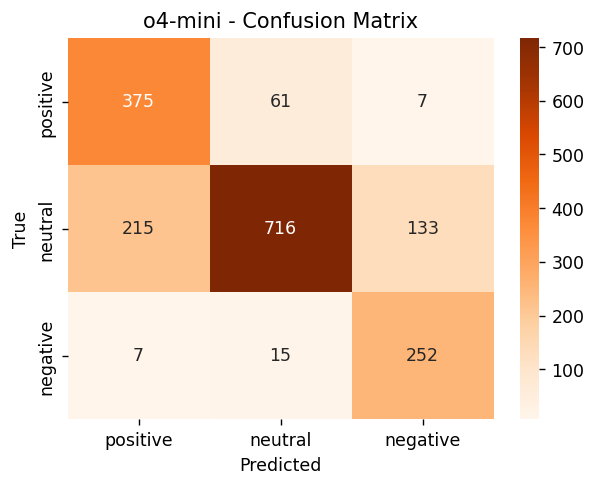

In [18]:
plot_confusion_matrix(
    true_labels,
    preds,
    labels=["positive", "neutral", "negative"],
    title="o4-mini - Confusion Matrix",
    cmap="Oranges",
)

In [19]:
print("False Positives:")
for i in range(len(preds)):
    if preds[i] == "positive" and true_labels[i] == "negative":
        print(sentences[i])

print("\nFalse Negatives:")
for i in range(len(preds)):
    if preds[i] == "negative" and true_labels[i] == "positive":
        print(sentences[i])

False Positives:
ING ING May Be Through The Worst Point Of The Cycle Read more stockmarket economy investing
Cencorp s net sales in the first quarter is estimated to be EUR091 2 m as compared to EUR4 5 m in the first quarter 2008
Bank of America sees demand surge for paycheck protection loans
Locked in some FB puts for nice gain
Core US PPI surprises on the downside
COST short finally making gains I will take half my gains at 147
Oil slips but holds near 2month high as looming OPEC meeting expected to yield deeper cuts

False Negatives:
Oil and gold rise after a US airstrike in Baghdad killed a top Iranian commander Asian stocks including Hong Ko
Gold Mine Output Falls For First Time Since 2008
4 beatendown Internet companies that may be ripe for a takeover target Twitter TWTR LinkedIn LNKD Yahoo YHOO Groupon GRPN
NEW Goldman Sachs fine for its role in the 1MDB scandal could be under 2 billion far less than what some anal
XOM 58 pre Exxon cuts fullyear capex forecast by 30 maintains lo

In [20]:
o4_results = per_source_metrics(true_labels, preds, val_df["source"])
print("o4-mini Per-Source Performance:\n")
for source, acc, f1 in o4_results:
    print(f"{source}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}")

o4-mini Per-Source Performance:

FPB: Accuracy=0.809, Macro-F1=0.819
Twitter: Accuracy=0.726, Macro-F1=0.714
FiQA: Accuracy=0.815, Macro-F1=0.737


## Save Results


In [21]:
pd.DataFrame(
    classification_report(true_labels, preds, output_dict=True)
).transpose().to_csv("../models/o4/o4-mini-preds.csv")

with open("../models/o4/o4-mini-preds.txt", "w") as f:
    for label in preds:
        f.write(label + "\n")

## Summary

The o4-mini model performs very well **without any fine-tuning**, highlighting the power of general LLMs on domain-specific tasks.
